In [1]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
data = pd.read_csv("./data/driving_log.csv")

In [3]:
data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [4]:
data.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


In [5]:
num_data = data.shape[0]
left_num_data = data['steering'].apply(lambda x: x < -0.01).sum()
right_num_data = data['steering'].apply(lambda x: x > 0.01).sum()
print("The number of left turn: {0} out of {1}".format(left_num_data, num_data))
print("The number of right turn: {0} out of {1}".format(right_num_data, num_data))

The number of left turn: 1696 out of 8036
The number of right turn: 1888 out of 8036


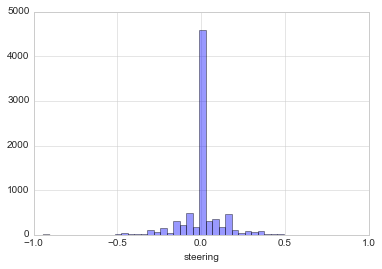

In [7]:
sns.set_style('whitegrid')
plot = sns.distplot(data['steering'], kde=False, rug=False)
figure = plot.get_figure() 
figure.savefig("hist.png")

__Comment__: The distribution of target data steering angle is zero biased since the data was generated by driving around a single track. Solution for this problem, we use some data agumentation like the followings.

## Data Augmentation

In [8]:
plt.rcParams["figure.figsize"] =(18,12)
cameras = ['left', 'center', 'right']
angle_adjust = [0.3, 0, -0.3]
img_folder = './data/IMG/'

### Generate recovery data by using left and right cameras while car is driving straight

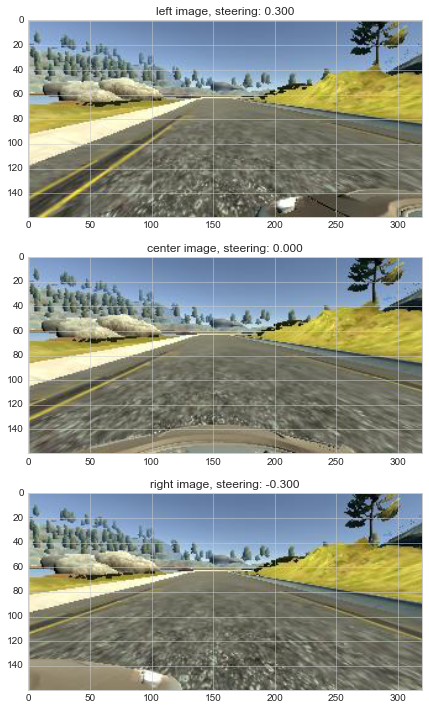

In [9]:
found = False
while not found:
    rindex = np.random.randint(num_data)
    if abs(data.loc[rindex, 'steering']) < 0.01:
        found = True
        
fig, axes = plt.subplots(3,1)
for i in range(3):
    path = img_folder + data.loc[rindex, cameras[i]].split('/')[-1]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steering = data.loc[rindex, 'steering'] + angle_adjust[i]
    axes[i].imshow(image)
    axes[i].set_title("{0} image, steering: {1:1.3f}".format(cameras[i], steering))

fig.savefig('multiple_cameras.png')

__Comment__: while car is driving straight, the images generated from the left and right are actually recovering back to the center with adjusted steering angle. As shown above, the car steers to the right in order to recover back to the center in the image from left camera, and the car steers to the left, at the same time, it also adding more diverse training data like more data with larger steering.

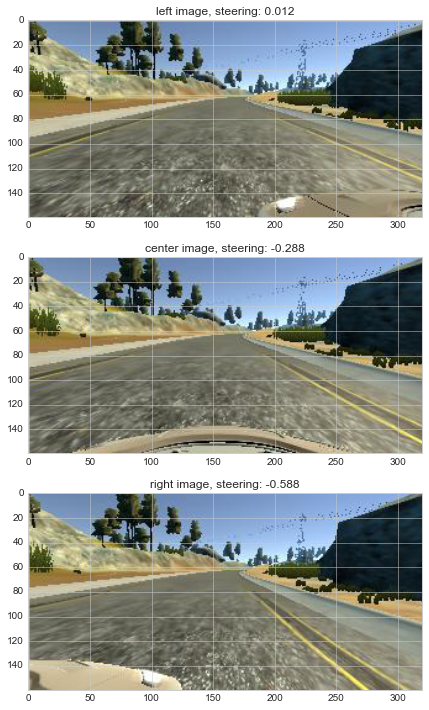

In [10]:
found = False
while not found:
    rindex = np.random.randint(num_data)
    if abs(data.loc[rindex, 'steering']) > 0.05:
        found = True
        
fig, axes = plt.subplots(3,1)
for i in range(3):
    path = img_folder + data.loc[rindex, cameras[i]].split('/')[-1]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steering = data.loc[rindex, 'steering'] + angle_adjust[i]
    axes[i].imshow(image)
    axes[i].set_title("{0} image, steering: {1:1.3f}".format(cameras[i], steering))

fig.savefig('multiple_cameras_angle.png')

### Flip the image (horizontally)

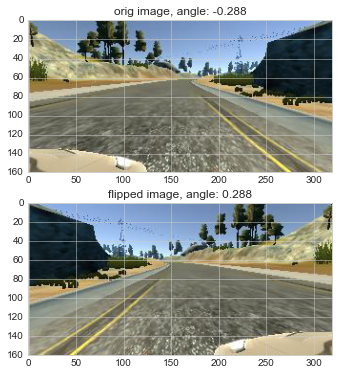

In [11]:
plt.rcParams["figure.figsize"] =(8,6)

fig, axes = plt.subplots(2,1)

path = img_folder + data.loc[rindex, cameras[i]].split('/')[-1]
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
steering = data.loc[rindex, 'steering']

image_flip = image[:,::-1,:]
steering_flip = -steering

axes[0].imshow(image)
axes[0].set_title('orig image, angle: {0:1.3f}'.format(steering))

axes[1].imshow(image_flip)
axes[1].set_title('flipped image, angle: {0:1.3f}'.format(steering_flip))

fig.savefig('flip.png')

### Shear image (horizontally) with randomness 

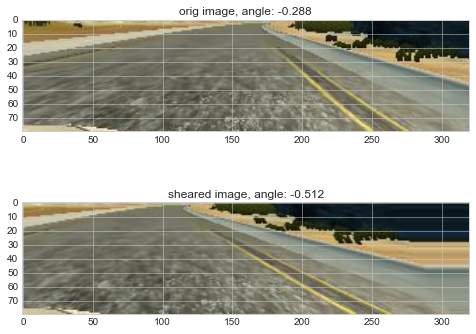

In [13]:
plt.rcParams["figure.figsize"] =(8,6)

fig, axes = plt.subplots(2,1)

shear_range = 200
rows, cols, ch = image.shape
dx = np.random.randint(-shear_range, shear_range + 1)
random_point = [cols / 2 + dx, rows / 2]
pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
pts2 = np.float32([[0, rows], [cols, rows], random_point])
dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
M = cv2.getAffineTransform(pts1, pts2)
image_shear = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
steering_shear = steering + dsteering


axes[0].imshow(image[60:140,:,:])
axes[0].set_title('orig image, angle: {0:1.3f}'.format(steering))

axes[1].imshow(image_shear[60:140,:,:])
axes[1].set_title('sheared image, angle: {0:1.3f}'.format(steering_shear))

fig.savefig('shear.png')

__Comment__: Shearring image horizontally provided data with great variety of steering angle, which allow us to train more generalized model. Above is showing the example after cropping off the sky and hood.

### Brighten image with randomness

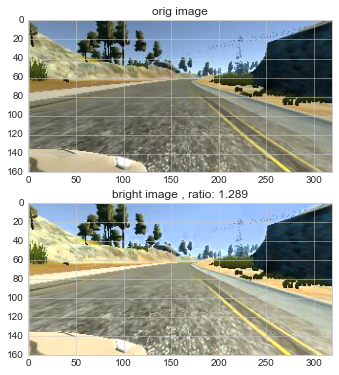

In [16]:
plt.rcParams["figure.figsize"] =(8,6)
fig, axes = plt.subplots(2,1)

image_bright = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
image_bright = np.array(image_bright, dtype = np.float32)
ratio = 0.5 + np.random.uniform()
image_bright[:,:,2] = image_bright[:,:,2] * ratio
image_bright[:,:,2][image_bright[:,:,2] > 255] = 255
image_bright = np.array(image_bright, dtype=np.uint8)
image_bright = cv2.cvtColor(image_bright, cv2.COLOR_HSV2RGB)

axes[0].imshow(image)
axes[0].set_title('orig image')

axes[1].imshow(image_bright)
axes[1].set_title('bright image , ratio: {0:1.3f}'.format(ratio))

fig.savefig('bright.png')

## Randomly throw away some data which is driving straight in data generator

In [181]:
def generator_angle(angle):
    i_lrc = np.random.randint(3)
    if i_lrc == 0:
        angle += 0.3
    elif i_lrc == 1:
        angle -= 0.3
    
    flip = np.random.randint(2)
    if flip == 0:
        angle *= -1
    
    dx = np.random.randint(-shear_range, shear_range + 1)
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    angle += dsteering
    return angle

In [205]:
data_steering_aug = np.zeros(num_data)
data = data.iloc[np.random.permutation(num_data)]
shear_range = 200

for i in range(num_data):
    keep = False
    index = np.random.randint(num_data)
    while not keep:
        angle = data.iloc[index, 3]
        angle = generator_angle(angle)
        if abs(angle) > 0.1:
            data_steering_aug[i] = angle
            keep = True
        elif np.random.uniform() > 0.7:
            data_steering_aug[i] = angle
            keep = True
    

In [ ]:
sns.set_style('whitegrid')
data_steering_aug = pd.Series(data_steering_aug, name="Steering after data augmentated")
plot = sns.distplot(data_steering_aug, kde=False, rug=False)
figure = plot.get_figure() 
figure.savefig("hist_after_augment.png")

__Comment__: The portion of data driving straight was signicantly cutted down. 

## Model architecture

Nvidia end-to-end self driving car architecture, with input 64x64, l2 reg conv and fully connected layers, dropout layer after flatten layer to lower the time and model complexity, adam learning rate adjusting scheme, learning rate 0.001 which is default.


In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers import Convolution2D, MaxPooling2D, ELU
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras import backend as K

batch_size = 64
reg = 0.001
lr = 0.001
keep_prob = 0.5
samples_per_epoch= 20032
nb_val_samples= 0.1 * samples_per_epoch


K.clear_session()
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), W_regularizer=l2(reg)))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, subsample=(2,2), W_regularizer=l2(reg)))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, subsample=(2,2), W_regularizer=l2(reg)))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, W_regularizer=l2(reg)))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, W_regularizer=l2(reg)))
model.add(ELU())
model.add(Flatten())
model.add(Dropout(keep_prob))
model.add(Dense(100, W_regularizer=l2(reg)))
model.add(Dense(50, W_regularizer=l2(reg)))
model.add(Dense(10))
model.add(Dense(1))

adam_opt = Adam(lr)
#model.fit(X_train, y_train, nb_epoch=1, validation_split=0.2, shuffle=True)

model.compile(loss='mse', optimizer=adam_opt)

Using TensorFlow backend.
E:\ML_app\Anaconda2\envs\carnd-term1\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [27]:
model.summary()
json_output = model.to_json()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 30, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 30, 30, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 13, 13, 36)    21636       elu_1[0][0]                      
___________________________________________________________________________________________

In [29]:
import json
print(json.loads(json_output))

{'config': [{'config': {'batch_input_shape': [None, 64, 64, 3], 'function_type': 'lambda', 'function': ['ã\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00C\x00\x00\x00s\x0c\x00\x00\x00|\x00\x00d\x01\x00\x1bd\x02\x00\x18S)\x03Nç\x00\x00\x00\x00\x00ào@ç\x00\x00\x00\x00\x00\x00à?©\x00)\x01Ú\x01xr\x03\x00\x00\x00r\x03\x00\x00\x00ú\x1f<ipython-input-17-b212dbef81ab>Ú\x08<lambda>\x13\x00\x00\x00s\x00\x00\x00\x00', None, None], 'output_shape_type': 'raw', 'arguments': {}, 'name': 'lambda_1', 'output_shape': None, 'trainable': True, 'input_dtype': 'float32'}, 'class_name': 'Lambda'}, {'config': {'subsample': [2, 2], 'W_constraint': None, 'nb_filter': 24, 'trainable': True, 'border_mode': 'valid', 'nb_row': 5, 'init': 'glorot_uniform', 'b_regularizer': None, 'activity_regularizer': None, 'nb_col': 5, 'activation': 'linear', 'dim_ordering': 'tf', 'b_constraint': None, 'bias': True, 'name': 'convolution2d_1', 'W_regularizer': {'name': 'L1L2Regularizer', 'l2': 0.0010000000474974513

## Result:

In [209]:
from IPython import display
display.HTML('<img src="{}">'.format('./submission_64x64/track1.gif'))

In [210]:
display.HTML('<img src="{}">'.format('./submission_64x64/track2.gif'))